# Data Cleaning and Exploration

In [1]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

def get_data(filepath):
    '''
    Converts all database files in filepath into a single Dataframe
    Also converts columns into the correct data type
    
    Tests whether columns are correct data type
    Prints 'Dataframe is working intended' if data types are correct
    Return will be 2 DataFrames, the first one is the String values and the second one will be integer values
    
    Returns None if DataFrames are not in correct formats
    '''
    # 2 queries, one for string value and one for integer values
    appended_data_string = [] 
    appended_data_ull = []
    
    # loop through all files in test/testdata
    for filename in os.listdir(filepath):
        if filename == '.ipynb_checkpoints':
            continue
            
        # create the sql connection
        cnx = sqlite3.connect(filepath + filename)

        # read as dataframe, set 'MEASUREMENT_TIME' as date time object
        sub_df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
        sub_df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)

        # append "Start Row"
        first_row_string = sub_df_string.loc[0]
        new_row_string = pd.DataFrame({'MEASUREMENT_TIME': first_row_string[0], 'ID_INPUT': first_row_string[1], 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
        sub_df_string = pd.concat([new_row_string, sub_df_string]).reset_index(drop=True)
        
        # append the informations
        appended_data_string.append(sub_df_string)
        appended_data_ull.append(sub_df_ull)

    # converting into 2 dataframes
    df_string = pd.concat(appended_data_string, ignore_index = True)
    df_ull = pd.concat(appended_data_ull, ignore_index = True)
    
    # preprocess the data
    df_string = preprocess(df_string)
    df_ull = preprocess(df_ull)
    
    # run tests on dataframe
    if (test_dataframe_string(df_string) and test_dataframe_ull(df_ull)):
        return df_string, df_ull
    
    # something went wrong!
    return None


def preprocess(df):
    '''
    Preprocess DataFrame so all data types are correct
    '''
    df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
    df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
    df = df[df['ID_INPUT'] == 3]
    
    if test_dataframe_string(df):
        df['VALUE'] = df['VALUE'].str.lower()
    
    return df

def test_dataframe_string(df):
    '''
    Checks whether the string DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, string, then integer
    if dtypes[0] == 'datetime64[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'object' and dtypes[3] == 'int32':
        return True
    
    return False
        

def test_dataframe_ull(df):
    '''
    Checks whether the ull DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, integer, then integer
    if dtypes[0] == 'datetime64[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'int64' and dtypes[3] == 'int32':
        return True
    
    return False

In [2]:
df_string, df_ull = get_data('test/testdata/')

In [3]:
df_string.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-12-01 06:14:49.924,3,s0,0
1,2021-12-01 06:14:49.924,3,explorer.exe,0
2,2021-12-01 06:14:50.950,3,esrv.exe,0
3,2021-12-01 06:14:51.461,3,teams.exe,0
4,2021-12-01 06:14:52.490,3,esrv.exe,0


In [4]:
df_string.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [5]:
df_ull.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
108,2021-12-01 06:20:16.046,3,1,0
153,2021-12-01 06:20:18.074,3,1,0
156,2021-12-01 06:20:18.591,3,1,0
161,2021-12-01 06:20:19.103,3,1,0
208,2021-12-01 06:20:21.140,3,1,0


In [6]:
df_ull.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                        int64
PRIVATE_DATA                 int32
dtype: object

In [7]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5]

chrome.exe      336
explorer.exe    243
zoom.exe        174
teams.exe       129
discord.exe      97
Name: VALUE, dtype: int64

In [8]:
num_apps = len(df_string[df_string['ID_INPUT'] == 3]['VALUE'].unique())
print('Number of Applications: ' + str(num_apps))

Number of Applications: 55


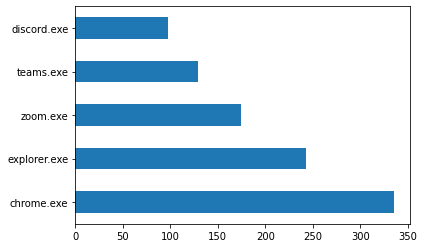

In [9]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plt.show()

In [10]:
df_string['VALUE'].value_counts()[-5:]

eadesktopinstaller.exe     1
code.exe                   1
accountscontrolhost.exe    1
werfault.exe               1
git-cmd.exe                1
Name: VALUE, dtype: int64

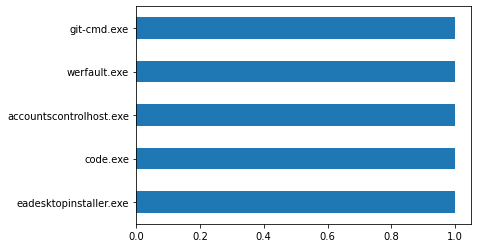

In [11]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[-5:].plot.barh(x = 'index', y = 'VALUE')
plt.show()

# Probability Matrix

In [12]:
# Only foreground data
df = df_string[df_string['ID_INPUT'] == 3] 

In [13]:
pairCount = defaultdict(int) # dict with pairs being keys
for i in range(df.shape[0]-1):
    pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
    pairCount[pair] += 1

In [14]:
pairProb = defaultdict(int)
for pair in pairCount:
    b_count = df[df['VALUE'] == pair[0]].shape[0]
    pairProb[pair] = pairCount[pair] / b_count

In [15]:
# Validation
# All Probabilities for each "B" add up to one showing we made the pairs and probabilties correctly
exes = df['VALUE'].unique()
for e in exes:
    pairs = []
    for k in pairProb.keys():
        if k[0] == e:
            pairs.append(k)
    sum_prob = 0
    for p in pairs:
        sum_prob += pairProb[p]
    if sum_prob != 1.0:
        print('Exe: ' + str(e) + '\t\tTotal Probability: ' + str(sum_prob))      

Exe: explorer.exe		Total Probability: 0.9958847736625509
Exe: chrome.exe		Total Probability: 0.9999999999999998
Exe: zoom.exe		Total Probability: 1.0000000000000002
Exe: discord.exe		Total Probability: 0.9999999999999998
Exe: shellexperiencehost.exe		Total Probability: 0.9999999999999999
Exe: microsoft.aad.brokerplugin.exe		Total Probability: 1.0000000000000002
Exe: startmenuexperiencehost.exe		Total Probability: 0.9999999999999999
Exe: db browser for sqlite.exe		Total Probability: 0.9999999999999999
Exe: steam.exe		Total Probability: 1.0000000000000002
Exe: steamwebhelper.exe		Total Probability: 0.9999999999999998
Exe: msedgewebview2.exe		Total Probability: 0.9999999999999999
Exe: eadesktop.exe		Total Probability: 0.9999999999999998
Exe: ts4_x64.exe		Total Probability: 0.9999999999999998


In [16]:
def getPred(numExe, start='s0'):
    pred = [start]
    for action in range(numExe-1):
        prev = pred[-1]
        max_prob = 0
        new_exe = ''
        for k in pairProb.keys():
            if k[0] == prev and pairProb[k] > max_prob:
                new_exe = k[1]
                max_prob = pairProb[k]
        pred.append(new_exe)
    print(pred)

In [17]:
getPred(7)

['s0', 'explorer.exe', 'chrome.exe', 'zoom.exe', 'chrome.exe', 'zoom.exe', 'chrome.exe']


In [18]:
getPred(5, 'DB Browser for SQLite.exe')

['DB Browser for SQLite.exe', '', '', '', '']


In [19]:
getPred(4, 'steamwebhelper.exe')

['steamwebhelper.exe', 'steam.exe', 'steamwebhelper.exe', 'steam.exe']


# Probability Matrix

In [20]:
pairProb # currently in a hard to read state

defaultdict(int,
            {('s0', 'explorer.exe'): 0.7428571428571429,
             ('explorer.exe', 'esrv.exe'): 0.07818930041152264,
             ('esrv.exe', 'teams.exe'): 0.0392156862745098,
             ('teams.exe', 'esrv.exe'): 0.007751937984496124,
             ('esrv.exe', 'explorer.exe'): 0.1568627450980392,
             ('teams.exe', 'explorer.exe'): 0.29457364341085274,
             ('esrv.exe', 's0'): 0.5882352941176471,
             ('explorer.exe', 'notepad.exe'): 0.00823045267489712,
             ('notepad.exe', 'explorer.exe'): 0.5,
             ('explorer.exe', 'teams.exe'): 0.12345679012345678,
             ('explorer.exe', 'chrome.exe'): 0.2716049382716049,
             ('chrome.exe', 'mcuicnt.exe'): 0.026785714285714284,
             ('mcuicnt.exe', 'chrome.exe'): 0.28125,
             ('chrome.exe', 'zoom.exe'): 0.27976190476190477,
             ('zoom.exe', 'chrome.exe'): 0.4482758620689655,
             ('zoom.exe', 'discord.exe'): 0.04597701149425287,
      

In [21]:
# let's see the probability for P(A|B) where B = 's0'
lst = []
for i in pairProb:
    if i[0] == 's0':
        lst.append([i, pairProb[i]])
lst

[[('s0', 'explorer.exe'), 0.7428571428571429],
 [('s0', 'esrv.exe'), 0.11428571428571428],
 [('s0', 'teams.exe'), 0.02857142857142857],
 [('s0', 'searchapp.exe'), 0.02857142857142857],
 [('s0', 'msedgewebview2.exe'), 0.02857142857142857],
 [('s0', 'microsoft.aad.brokerplugin.exe'), 0.02857142857142857],
 [('s0', 'discord.exe'), 0.02857142857142857]]

In [22]:
all_exe = df['VALUE'].unique() # gather all unique .exe
prob = [] # vlaues for dataframe

# i = event B
for i in all_exe:
    temp_list = []
    # j = event A
    for j in all_exe:
        exe_set = (i, j) # create a set
        
        try: # see if the set is in one of the pairings
            temp_list.append(pairProb[exe_set])
        except: # if set is not in pairing, then the probability is 0
            temp_list.append(0)
            
    prob.append(temp_list)

prob_matrix = pd.DataFrame(prob, index = all_exe, columns = all_exe)

In [23]:
prob_matrix

,s0,explorer.exe,esrv.exe,teams.exe,notepad.exe,chrome.exe,mcuicnt.exe,zoom.exe,discord.exe,shellexperiencehost.exe,...,eadesktopinstaller.exe,eadesktop.exe,peggle.exe,installer.exe,ts4_x64.exe,taskmgr.exe,screenclippinghost.exe,razer synapse 3.exe,razer central.exe,git-cmd.exe
s0,0.000000,0.742857,0.114286,0.028571,0.00000,0.000000,0.000000,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
explorer.exe,0.008230,0.004115,0.078189,0.123457,0.00823,0.271605,0.000000,0.098765,0.053498,0.024691,...,0.000000,0.024691,0.000000,0.004115,0.000000,0.000000,0.000000,0.004115,0.0,0.000000
esrv.exe,0.588235,0.156863,0.000000,0.039216,0.00000,0.019608,0.000000,0.019608,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.0,0.000000
teams.exe,0.000000,0.294574,0.007752,0.000000,0.00000,0.372093,0.038760,0.015504,0.077519,0.007752,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
notepad.exe,0.000000,0.500000,0.000000,0.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
chrome.exe,0.000000,0.130952,0.026786,0.148810,0.00000,0.000000,0.026786,0.279762,0.125000,0.026786,...,0.000000,0.017857,0.000000,0.000000,0.002976,0.002976,0.002976,0.005952,0.0,0.000000
mcuicnt.exe,0.000000,0.187500,0.062500,0.125000,0.00000,0.281250,0.000000,0.093750,0.000000,0.000000,...,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
zoom.exe,0.000000,0.172414,0.005747,0.005747,0.00000,0.448276,0.022989,0.028736,0.045977,0.011494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
discord.exe,0.000000,0.082474,0.051546,0.082474,0.00000,0.443299,0.000000,0.123711,0.000000,0.000000,...,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
shellexperiencehost.exe,0.000000,0.206897,0.000000,0.000000,0.00000,0.172414,0.000000,0.034483,0.241379,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [24]:
prob_matrix.sum(axis = 1)

s0                                   1.000000
explorer.exe                         0.995885
esrv.exe                             1.000000
teams.exe                            1.000000
notepad.exe                          1.000000
chrome.exe                           1.000000
mcuicnt.exe                          1.000000
zoom.exe                             1.000000
discord.exe                          1.000000
shellexperiencehost.exe              1.000000
msedge.exe                           1.000000
origin.exe                           1.000000
microsoft.aad.brokerplugin.exe       1.000000
utility.exe                          1.000000
vpnui.exe                            1.000000
docker desktop.exe                   1.000000
searchapp.exe                        1.000000
devenv.exe                           1.000000
code.exe                             1.000000
startmenuexperiencehost.exe          1.000000
mintty.exe                           1.000000
razer synapse service process.exe 

# HMM

In [46]:
#!pip install hmmlearn

In [47]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [48]:
enc = OneHotEncoder()
enc.fit(all_exe.reshape(-1, 1))

OneHotEncoder()

In [49]:
allSets = []

for i in range(df.shape[0]-1):
    pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
    allSets.append(pair)
    
allSets[:5]

[('s0', 'explorer.exe'),
 ('explorer.exe', 'esrv.exe'),
 ('esrv.exe', 'Teams.exe'),
 ('Teams.exe', 'esrv.exe'),
 ('esrv.exe', 'explorer.exe')]

In [41]:
X = [i[0] for i in allSets]
y = [i[1] for i in allSets]

print(X[:5])
print(y[:5])

['s0', 'explorer.exe', 'esrv.exe', 'Teams.exe', 'esrv.exe']
['explorer.exe', 'esrv.exe', 'Teams.exe', 'esrv.exe', 'explorer.exe']


In [66]:
enc.transform(X.reshape(-1, 1))

AttributeError: 'list' object has no attribute 'reshape'

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
model = hmm.GaussianHMM()

In [49]:
model.fit(allSets)

C:\Users\andyd\AppData\Local\Programs\Python\Python310\lib\site-packages\hmmlearn\base.py:440: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

# Checking for anomalies

In [25]:
df_string['MEASUREMENT_TIME'].min()

Timestamp('2021-12-01 06:14:49.924000')

In [26]:
df_string['MEASUREMENT_TIME'].max()

Timestamp('2022-01-14 05:56:05.688000')

In [68]:
#df_string[df_string['VALUE'] == 'Steam.exe']

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
1540,2021-12-23 06:05:24.216,3,Steam.exe,0


In [69]:
#df_string_cleaned = df_string.replace('Steam.exe', 'steam.exe')
#df_string_cleaned.loc[1540]

MEASUREMENT_TIME    2021-12-23 06:05:24.216000
ID_INPUT                                     3
VALUE                                steam.exe
PRIVATE_DATA                                 0
Name: 1540, dtype: object

# Total Time Column

In [27]:
df_string

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-12-01 06:14:49.924,3,s0,0
1,2021-12-01 06:14:49.924,3,explorer.exe,0
2,2021-12-01 06:14:50.950,3,esrv.exe,0
3,2021-12-01 06:14:51.461,3,teams.exe,0
4,2021-12-01 06:14:52.490,3,esrv.exe,0
...,...,...,...,...
2714,2022-01-14 05:55:48.841,3,mintty.exe,0
2715,2022-01-14 05:55:54.972,3,explorer.exe,0
2716,2022-01-14 05:55:57.523,3,mintty.exe,0
2717,2022-01-14 05:56:00.079,3,chrome.exe,0


In [28]:
df_string_cleaned = df_string.copy()
df_string_cleaned['USE_TIME'] = df_string_cleaned['MEASUREMENT_TIME'].diff().dt.total_seconds() / 60

In [29]:
use_time = df_string_cleaned.groupby('VALUE')['USE_TIME'].sum().sort_values(ascending = False)
use_time

VALUE
s0                                   56139.579867
lockapp.exe                           4504.127917
explorer.exe                           476.940317
zoom.exe                               321.314400
chrome.exe                             317.828317
discord.exe                            300.682783
searchapp.exe                          290.310133
microsoft.aad.brokerplugin.exe         184.950950
shellexperiencehost.exe                175.862950
xboxpcapp.exe                          162.114617
teams.exe                               99.474333
time.exe                                72.399950
msedgewebview2.exe                      54.357200
msedge.exe                              51.175483
esrv.exe                                47.658750
mcuicnt.exe                             33.956367
screenclippinghost.exe                  19.417650
devenv.exe                              15.809950
steam.exe                               14.266333
uihost.exe                               8.7

In [30]:
df_string_cleaned['USE_TIME'] = (df_string_cleaned['VALUE'] != 's0').astype('int64') * df_string_cleaned['USE_TIME']
df_string_cleaned

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
0,2021-12-01 06:14:49.924,3,s0,0,NaN
1,2021-12-01 06:14:49.924,3,explorer.exe,0,0.000000
2,2021-12-01 06:14:50.950,3,esrv.exe,0,0.017100
3,2021-12-01 06:14:51.461,3,teams.exe,0,0.008517
4,2021-12-01 06:14:52.490,3,esrv.exe,0,0.017150
...,...,...,...,...,...
2714,2022-01-14 05:55:48.841,3,mintty.exe,0,0.008867
2715,2022-01-14 05:55:54.972,3,explorer.exe,0,0.102183
2716,2022-01-14 05:55:57.523,3,mintty.exe,0,0.042517
2717,2022-01-14 05:56:00.079,3,chrome.exe,0,0.042600


In [31]:
df_string_cleaned['USE_TIME'] = df_string_cleaned['USE_TIME'].fillna(0)
df_string_cleaned

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
0,2021-12-01 06:14:49.924,3,s0,0,0.000000
1,2021-12-01 06:14:49.924,3,explorer.exe,0,0.000000
2,2021-12-01 06:14:50.950,3,esrv.exe,0,0.017100
3,2021-12-01 06:14:51.461,3,teams.exe,0,0.008517
4,2021-12-01 06:14:52.490,3,esrv.exe,0,0.017150
...,...,...,...,...,...
2714,2022-01-14 05:55:48.841,3,mintty.exe,0,0.008867
2715,2022-01-14 05:55:54.972,3,explorer.exe,0,0.102183
2716,2022-01-14 05:55:57.523,3,mintty.exe,0,0.042517
2717,2022-01-14 05:56:00.079,3,chrome.exe,0,0.042600


In [32]:
df_string_cleaned[df_string_cleaned['VALUE'] == 'lockapp.exe']

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
1313,2021-12-12 20:47:11.563,3,lockapp.exe,0,3556.649100
1483,2021-12-17 22:18:09.627,3,lockapp.exe,0,15.427850
1485,2021-12-18 00:27:25.396,3,lockapp.exe,0,129.192467
1912,2021-12-27 06:13:11.398,3,lockapp.exe,0,12.520683
1914,2021-12-27 06:24:41.645,3,lockapp.exe,0,11.478683
1916,2021-12-27 06:45:13.022,3,lockapp.exe,0,20.505783
2010,2022-01-04 08:49:02.631,3,lockapp.exe,0,665.399300
2333,2022-01-11 22:01:31.031,3,lockapp.exe,0,15.992967
2365,2022-01-12 04:57:49.943,3,lockapp.exe,0,76.961083


In [33]:
# should we drop lockapp?
df_string_cleaned.drop(df_string_cleaned[df_string_cleaned['VALUE'] == 'lockapp.exe'].index, inplace = True)

In [34]:
df_string_cleaned[df_string_cleaned['VALUE'] == 'lockapp.exe'] # should be empty dataframe because we dropped any rows with value 'lockapp.exe'

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME


In [35]:
df_string_cleaned[df_string_cleaned['VALUE'] == 'searchapp.exe']

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
653,2021-12-03 00:31:04.462,3,searchapp.exe,0,0.357250
1020,2021-12-03 06:36:39.105,3,searchapp.exe,0,0.016950
1026,2021-12-03 06:36:42.653,3,searchapp.exe,0,0.008417
1256,2021-12-07 05:53:27.809,3,searchapp.exe,0,0.008500
1367,2021-12-13 01:15:07.138,3,searchapp.exe,0,1.048067
1415,2021-12-15 06:46:41.002,3,searchapp.exe,0,0.135067
1420,2021-12-15 07:00:23.019,3,searchapp.exe,0,4.914250
1422,2021-12-15 07:00:27.624,3,searchapp.exe,0,0.034200
1426,2021-12-15 07:01:01.926,3,searchapp.exe,0,0.486533
1508,2021-12-21 01:13:13.803,3,searchapp.exe,0,0.008450


In [36]:
df_string_cleaned[df_string_cleaned['VALUE'] == 'searchapp.exe'].mean()

ID_INPUT        3.000000
PRIVATE_DATA    0.000000
USE_TIME        5.005347
dtype: float64

In [37]:
df_string_cleaned.loc[1850:1862] # 82 minutes?

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
1850,2021-12-27 00:36:28.791,3,searchapp.exe,0,0.025317
1851,2021-12-27 00:36:30.304,3,applicationframehost.exe,0,0.025217
1852,2021-12-27 00:36:47.598,3,admin app,0,0.288233
1853,2021-12-27 00:36:51.645,3,shellexperiencehost.exe,0,0.067450
1854,2021-12-27 00:37:12.910,3,systemsettings.exe,0,0.354417
1855,2021-12-27 00:37:18.987,3,red-win64-shipping.exe,0,0.101283
1856,2021-12-27 00:37:22.523,3,searchapp.exe,0,0.058933
1857,2021-12-27 00:37:25.044,3,applicationframehost.exe,0,0.042017
1858,2021-12-27 00:37:37.175,3,red-win64-shipping.exe,0,0.202183
1859,2021-12-27 01:59:49.540,3,searchapp.exe,0,82.206083


# Graphs

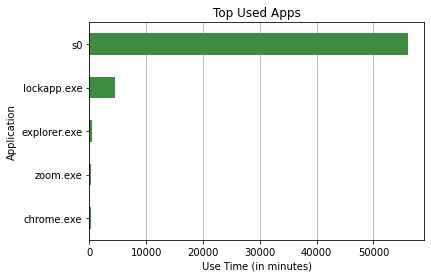

In [38]:
ax = use_time[:5].plot.barh(color = '#3D8C40')
ax.set_axisbelow(True)
ax.set_xlabel('Use Time (in minutes)')
ax.set_ylabel('Application')
ax.set_title('Top Used Apps')
ax.invert_yaxis()
plt.grid(axis = 'x')
plt.show()

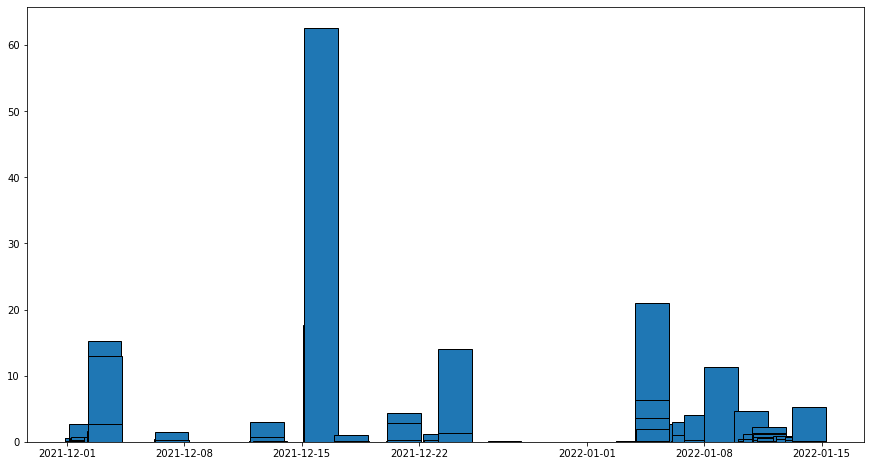

In [40]:
# plan to aggregate for a better plot
chrome = df_string_cleaned[df_string_cleaned['VALUE'] == 'chrome.exe']
x = chrome['MEASUREMENT_TIME']
y = chrome['USE_TIME']


plt.rcParams["figure.figsize"] = (15, 8)
ax = plt.subplot()
ax.bar(x, y, width = 2, edgecolor = 'black')
ax.xaxis_date()

plt.show()